In [12]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from opacus import PrivacyEngine

from resnet_gn import ResNetGN18

device = torch.device(f'cuda' if torch.cuda.is_available() else 'cpu') 

In [ ]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform_test)
trainloader = torch.utils.data.DataLoader(cifar10, batch_size=128,shuffle=False)

test = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform_test)
testloader = torch.utils.data.DataLoader(test, batch_size=128,shuffle=False)
len(cifar10), len(test)

(50000, 10000)

In [5]:
import pandas as pd

In [6]:
def load_scores_from_dir(score_dir):
    scores = pd.DataFrame()
    for i in range(10):
        score_path = f'./curv_scores/{score_dir}/epoch_{(i+1)*4}_scores.pt'
        scores[f'Epoch {(i+1) * 10}'] = torch.load(score_path, weights_only=True).numpy()
    scores['Mean Score'] = scores.mean(axis=1)
    return scores

In [7]:
standard_scores = load_scores_from_dir('standard')
standard_scores.head()

,Epoch 10,Epoch 20,Epoch 30,Epoch 40,Epoch 50,Epoch 60,Epoch 70,Epoch 80,Epoch 90,Epoch 100,Mean Score
0,0.000395,0.000848,0.001562,0.005626,7.373449e-05,0.003897,1.056842e-04,4.233517e-03,1.798784e-03,1.805653e-03,0.002035
1,0.000038,0.000037,0.000037,0.000003,1.563671e-05,0.000008,2.742983e-06,2.158309e-05,3.770253e-06,3.692100e-06,0.000017
2,0.000213,0.001148,0.002460,0.001311,1.403520e-03,0.000316,1.607568e-05,7.864768e-04,1.264754e-03,1.053206e-04,0.000902
3,0.000610,0.000038,0.000236,0.000341,6.729361e-05,0.000083,1.661113e-04,1.845123e-05,3.260997e-06,7.243918e-07,0.000156
4,0.000270,0.000035,0.000024,0.000002,2.606614e-07,0.000009,8.752781e-07,1.481802e-07,9.990397e-08,9.733709e-08,0.000034


In [8]:
eps10_scores = load_scores_from_dir('eps10')
eps10_scores.head()

,Epoch 10,Epoch 20,Epoch 30,Epoch 40,Epoch 50,Epoch 60,Epoch 70,Epoch 80,Epoch 90,Epoch 100,Mean Score
0,0.000184,0.000218,0.000242,0.000313,0.000320,0.000280,0.000226,0.000291,0.000138,0.000276,0.000249
1,0.000217,0.000271,0.000245,0.000245,0.000235,0.000198,0.000179,0.000267,0.000154,0.000240,0.000225
2,0.000129,0.000196,0.000132,0.000186,0.000223,0.000140,0.000125,0.000167,0.000100,0.000178,0.000157
3,0.000217,0.000285,0.000263,0.000279,0.000450,0.000330,0.000285,0.000312,0.000150,0.000382,0.000295
4,0.000158,0.000298,0.000237,0.000272,0.000262,0.000207,0.000182,0.000205,0.000194,0.000314,0.000233


In [20]:
net = ResNetGN18()
net.load_state_dict(torch.load('./eps10/epoch_4.pth', weights_only=True), strict=False)
net.to(device)
print('saved')

saved


In [21]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the train images: 10 %


In [22]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 10 %


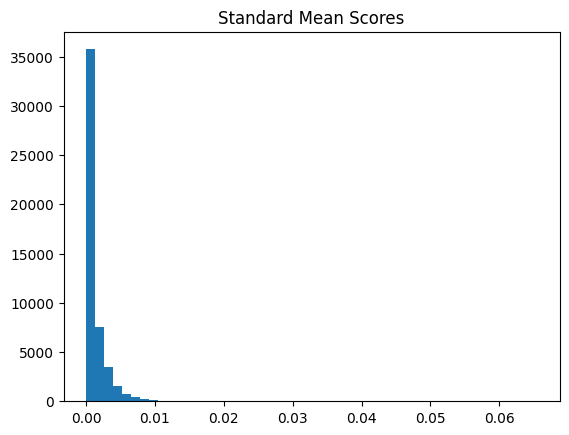

In [25]:
plt.hist(standard_scores['Mean Score'], bins=50)
plt.title('Standard Mean Scores')
plt.show()

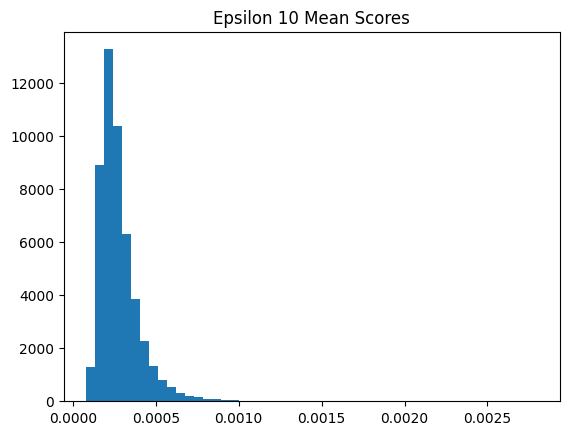

In [26]:
plt.hist(eps10_scores['Mean Score'], bins=50)
plt.title('Epsilon 10 Mean Scores')
plt.show()

In [27]:
combined_df = pd.DataFrame({
    'std': standard_scores['Mean Score'],
    'e10': eps10_scores['Mean Score']
})

combined_df['diff'] = combined_df['e10'] - combined_df['std']

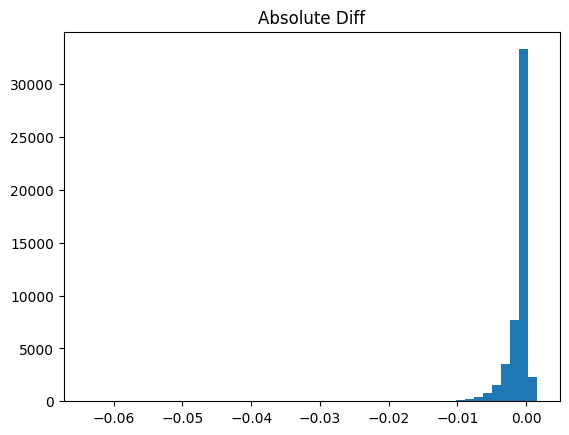

In [28]:
plt.hist(combined_df['diff'], bins=50)
plt.title('Absolute Diff')
plt.show()

In [30]:
combined_df['std rank'] = combined_df['std'].rank(ascending=False)
combined_df['e10 rank'] = combined_df['e10'].rank(ascending=False)
combined_df['rank diff'] = combined_df['e10 rank'] - combined_df['std rank']

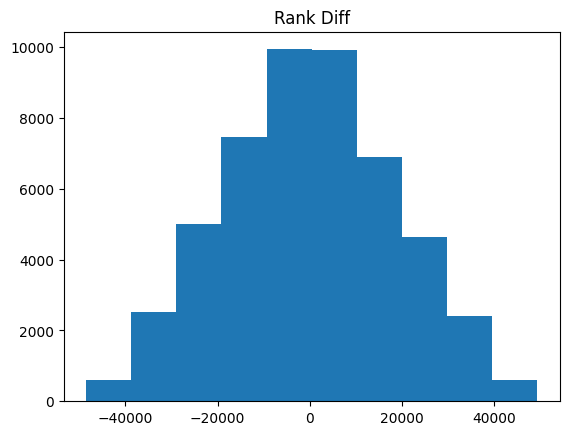

In [31]:
plt.hist(combined_df['rank diff'], bins=10)
plt.title('Rank Diff')
plt.show()

In [32]:
def spearman(rankx, ranky):
    total = 0
    n = len(rankx)
    for i in range(n):
        total += (rankx[i] - ranky[i]) ** 2
    return 1 - 6 * total / (n * (n ** 2 - 1))

In [33]:
spearman(combined_df['std rank'].to_numpy(), combined_df['e10 rank'].to_numpy())

np.float64(0.18180190801605678)